# ALMA-MUSE-JWST - RGB image

This notebook produces an RGB (false 3-colour) image from James Webb Space Telescope (JWST) observations of the galaxy NGC 4321.

We use the following filters:
* red = `H-alpha` ionised gas emission (MUSE)
* green = `F770W` polycyclic aromatic hydrocarbon (PAH) dust emission (JWST)
* blue = `CO(2-1)` molecular line emission (ALMA)

Similarly to the previous notebooks (`1_hst_rgb_image.ipynb`, `2_jwst_rgb_image`), we use Lupton RGB package.

We use ALMA, MUSE and JWST observations of the nearby, spiral galaxy NGC 4321 (M100). 
The data is coming from the PHANGS collaboration and is publicly available via: https://sites.google.com/view/phangs/home/data?authuser=0

### Load packages

In [1]:
import numpy as np  # work with data as numpy arrays
from astropy.io import fits  # load FITS files
from astropy.wcs import WCS  # coordinate system from FITS file
import matplotlib.pyplot as plt  # plotting
from astropy.visualization import make_lupton_rgb  # RGB image from 3 images, using arcsinh stretch
from PIL import Image, ImageEnhance  # image manipulation
from reproject import reproject_interp # reproject pixel grid
import warnings
warnings.filterwarnings("ignore")  # mute warnings

### Load data

In [2]:
# directories
data_dir = '../data/'  # data directory, edit as needed
image_dir = '../images/' # directory to save created images, edit as needed

In [3]:
# file names
galaxy = 'ngc4321'
muse_ha_fits = data_dir + 'muse/' + galaxy + '_muse_hacorr.fits'
jwst_770_fits = data_dir + 'jwst/' + galaxy + '_miri_lv3_f770w_i2d_anchor.fits'
alma_co_fits = data_dir + 'alma/' + galaxy + '_12m+7m+tp_co21_broad_mom0.fits'

# load fits files
muse_ha, muse_header = fits.getdata(muse_ha_fits, header=True)
hdu_jwst_770 = fits.open(jwst_770_fits)[1]
jwst_770, jwst_header = hdu_jwst_770.data, hdu_jwst_770.header
alma_co, alma_header = fits.getdata(alma_co_fits, header=True)

# get coordinate systems
wcs_muse = WCS(muse_header)
wcs_jwst = WCS(jwst_header)
wcs_alma = WCS(alma_header)

### Regridding
The images are on different pixel grids, so need to reproject to a common grid. Here, we select the **JWST** grid.

In [4]:
# reproject MUSE andALMA maps to JWST grid
muse_ha, _ = reproject_interp((muse_ha, muse_header), jwst_header)
alma_co, _ = reproject_interp((alma_co, alma_header), jwst_header)

### Create RGB image

In [5]:
# relative scaling of colours
scaling_red = 1
scaling_green = 1.2
scaling_blue = 1

# define red, green, and blue images
image_r = muse_ha/np.nanmax(muse_ha) * scaling_red
image_g = jwst_770/np.nanmax(jwst_770) * scaling_green
image_b = alma_co/np.nanmax(alma_co) * scaling_blue

# make 3-color image
rgb_fname = image_dir + galaxy + '_muse_jwst_alma_rgb_image.jpg'
image_rgb = make_lupton_rgb(image_r, image_g, image_b, minimum=0, stretch=0.03, Q=10, filename=rgb_fname)

# edit saturation
image_rgb = Image.open(rgb_fname)
converter = ImageEnhance.Brightness(image_rgb)
image_rgb = converter.enhance(1.5)

# save image to jpg
image_rgb.save(rgb_fname) 

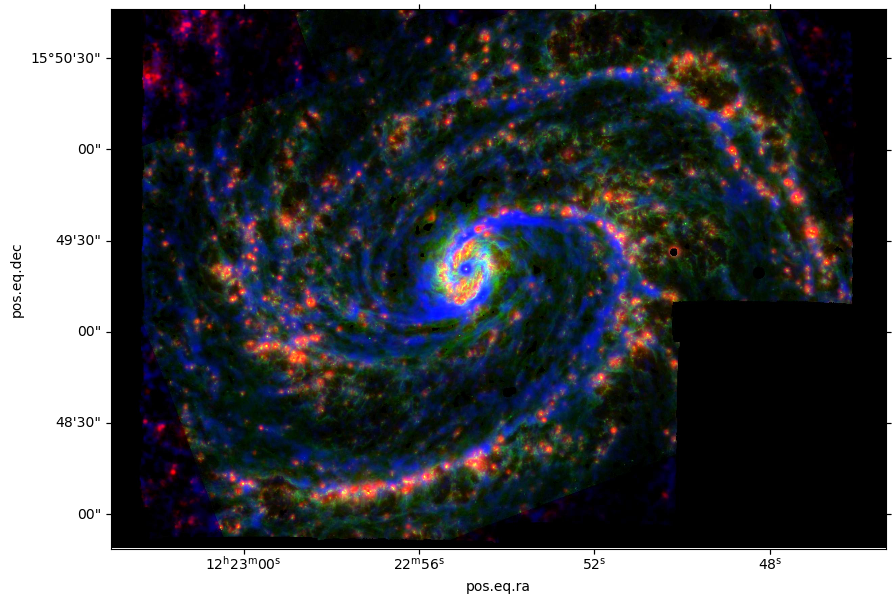

In [6]:
# plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs_jwst)

# plot rgb image
im = ax.imshow(image_rgb, transform=ax.get_transform(wcs_jwst))

plt.xlim(200,2500)
plt.ylim(200,1800)

plt.show()